## 衝撃波菅の厳密解

<img src="img/exact.png">

こちらが厳密解を解くためのプログラム部分です。

#### ■ 領域1：$ x>x_{0}+V_{s}t$
$\rho_{1}=\rho_{R}$, $p_{1}=p_{R}$, $u_{1}=u_{R}$

衝撃波速度$ V_{s}=u_{1}+c_{1}\sqrt{\frac{\gamma + 1}{2\gamma}\big(\frac{p_{2}}{p_{1}-1}+1\big)}$

#### ■ 領域2：$ x_{0}+V_{c}t < x \leq x_{0}+V_{s}t$

衝撃波の前後でランキン・ユゴニオの関係式より、$\frac{\rho_{2}}{\rho_{R}}=\frac{\frac{p_{2}}{p_{R}}+\frac{\gamma-1}{\gamma+1}}{\frac{\gamma-1}{\gamma+1}\frac{p_{2}}{p_{R}}+1}$

$u_{2}=u_{R}+\frac{c_{R}\big(\frac{p_{2}}{p_{R}}-1\big)}{\sqrt{\frac{\gamma}{2}\big(\gamma-1+\frac{p_{2}}{p_{R}}(\gamma+1)\big)}}$

#### ■ 領域3：$x_{0}+V_{rt}t < x \leq x_{0}+V_{c}t$ $(V_{rt}=u_{2}-\frac{\gamma-1}{2}(u_{L}-u_{2})+c_{L})=u_{3}-c_{3}$

等エントロピー過程よりポアソンの式を使って、$p_{3}\rho_{3}^{\gamma}=p_{L}\rho_{L}^{\gamma}$,流速と圧力は変化がないので$u_{3}=u_{2}=V_{c}$, $p_{3}=p_{2}$
$c_{3}=\sqrt{\frac{\gamma p_{3}}{\rho_{3}}}=\frac{\gamma-1}{2}(u_{L}-u_{3})+c_{L}$

#### ■ 領域4：$x_{0}+V_{rh}t < x \leq x_{0}+V_{rt}t$

流速$u_{4}=\frac{2}{\gamma+1}\big(\frac{x-x_{0}}{t}+c_{L}+\frac{\gamma-1}{2}u_{L}\big)$

音速$c_{4}=c_{L}-\frac{\gamma-1}{2}(u_{4}-u_{L})$

等エントロピー過程よりポアソンの式を使って、$p_{4}\rho_{4}^{\gamma}=p_{L}\rho_{L}^{\gamma}$ or $p_{4}c_{4}^{\frac{2\gamma}{\gamma-1}}=p_{L}c_{L}^{\frac{2\gamma}{\gamma-1}}$

#### ■ 領域5：$x\leq x_{0}+V_{rh}t$

$p_{5}=p_{L}$, $u_{5}=u_{L}$, $\rho_{5}=\rho_{L}$


## 計算手順

### 1. $p_{21}=\frac{p_{2}}{p_{1}}$を求める
まずは$\frac{p_{2}}{p_{1}}=p_{21}$を求めるための反復計算を行っています。
\begin{align*}
\frac{p_{2}}{p_{1}}=\frac{p_{R}}{p_{L}}\bigg(\,\,\,1+ \frac{\gamma-1}{2c_{L}}\bigg(u_{L}-u_{R}-\frac{c_{R}(\frac{p_{2}}{p_{1}}-1)}{\gamma\sqrt{\frac{\gamma+1}{2\gamma}}(\frac{p_{2}}{p_{1}}-1)+1}\bigg)\,\,\,\bigg)^{\frac{2\gamma}{\gamma-1}}
\end{align*}は

```python
# p21を求めるための関数
def F(p21, p1, p5, rho1, rho5, u1, u5):
    # c1, c5, w
    c1 = np.sqrt(gamma*p1/rho1)
    c5 = np.sqrt(gamma*p5/rho5)
    ....

```

の関数から求めています。

### 2. $p_{21}$の結果から各領域2~5の物理量を求める

各領域2~5の物理量は、

```python
# 厳密解の時間発展
def exact_solution(t):
    #Secant反復法により、衝撃波前後の圧力ジャンプを求める
    p21 = p1 / p5
    pm = p21 + 0.01
```

の関数から求めています。

#### (補足)理想気体の状態方程式（熱力学）
理想気体の状態方程式から、温度と密度と圧力は$p=\rho R_{MW} T$ 

ただし、$R_{MW}$は気体定数$R=8.31$[J/mol K]と空気のモル質量$MW=28.9$[g/mol]から、$R_{MW}=\frac{R}{MW}$[J/kg K]で計算される気体の種類による定数値であることに注意する必要があります。

OpenFOAMのrhoCentralFoamのshock tubeのチュートリアルでは「constant/thermophysicalProperties」で定圧比熱$C_{p}=1005$[J/kg K]とモル質量$MW=28.9$[g/mol]が与えれています。

ここから、$R_{MW}=\frac{R}{MW}=287.5$[J/kg K]と求まります。

また、マイヤーの関係式$C_{p} = C_{v} + R_{MW}$を使って比熱比$\gamma = \frac{C_{p}}{C_{v}} = \frac{C_{p}}{C_{v} - R_{MW}} = 1.4$と求めることができます。

※比熱や気体定数の単位を[J/kg K]にするか[J/mol K]にするかによって値が変わるので計算の際には注意が必要です。

OpenFOAMの定圧比熱$C_{p}$は単位[J/kg K]として与えられているので、ここでは[J/kg K]をベースに計算しました。

理論計算式において、計算を楽にするために比熱比$\gamma = 1.4$を使います。

In [32]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
 
gamma = 1.4              # 比熱比
XL = -5.0                # x最小値
XR = 5.0                 # x最大値
tstop = 0.007            # 計算終了時間
dt = 1e-3                # 時間刻み幅
t = 0              
i_max = 100
dx = (XR - XL) / i_max   # 空間刻み幅
x = np.zeros(i_max)
rhoe = np.zeros(i_max)
pe = np.zeros(i_max)
ue = np.zeros(i_max)
tempe = np.zeros(i_max)

x0 = 0 #初期区切り位置
R = 8.31446262  #[mol/J K]
MW = 28.96/1000 #[kg/mil]
Rmw = R/MW

# 初期状態1
p1 = 10000#0.1
T1 = 278.746
rho1 = p1/(Rmw*T1)#0.12
u1 = 0.0
c1 = np.sqrt(gamma * p1 / rho1)
if t == 0: print(f"初期状態 rho1={rho1}")

# 初期状態5
T5 = 348.432
p5 = 100000#1.0
rho5 = p5/(Rmw*T5)#1.0
u5 = 0.0
c5 = np.sqrt(gamma * p5 / rho5)
if t == 0: print(f"初期状態 rho5={rho5}")
 
for i in range(i_max):
    x[i] = XL + dx*i       # セル境界の座標

    # 高圧、高温
    if x[i] < x0: 
        rhoe[i] = rho5
        pe[i] = p5
        ue[i] = u5
        tempe[i] = pe[i]/(rhoe[i]*Rmw)
        
    # 低圧、低温
    else:
        rhoe[i] = rho1
        pe[i] = p1
        ue[i] = u1

#温度の計算    
tempe[i] = pe[i]/(rhoe[i]*Rmw)

初期状態 rho1=0.1249556012019438
初期状態 rho5=0.9996462441060816


続いて厳密解を解くための関数を用意します。

In [8]:
# p21を求めるための関数
def F(p21, p1, p5, rho1, rho5, u1, u5):
    # c1, c5, w
    c1 = np.sqrt(gamma*p1/rho1)
    c5 = np.sqrt(gamma*p5/rho5)
 
    w = p5/ p1*(
        1.0 + (gamma - 1)/ c5 / 2.0
        * (u5 - u1 - c1 / gamma * (p21 - 1.0)
        * (
                (gamma + 1.0) / (2.0*gamma) * (p21 - 1.0) + 1.0
            )**(-1.0 / 2.0)
                
        )
        
        )**(2 * gamma / (gamma - 1))  - p21
    return w

# 厳密解の時間発展
def exact_solution(t):
    #Secant反復法により、衝撃波前後の圧力ジャンプを求める
    p21 = p1 / p5
    pm = p21 + 0.01
    pmm = pm + 0.01
    fmm = F(pm, p1, p5, rho1, rho5, u1, u5)
    itmax = 20                                    # 反復回数の上限
    it = 0
    eps = 1.e-5                                   # 収束判定条件
    error = 1

    while error > eps:
        it += 1
        fm = F(p21, p1, p5, rho1, rho5, u1, u5)
        df = fm - fmm
        p21 = p21 - (p21 - pmm) * fm / (df + 1.0e-8 * df / (abs(df) + 1.0e-8))
        error = abs(p21 - pm) / pm
        pmm = pm
        pm = p21
        fmm = fm
        #print(f"反復回数={it},{p21}");

        if (it >= itmax):
            break
    
    #print(f"p21={p21}")

    #領域2の物理量を計算する
    rho2 = rho1 * (p21 + (gamma - 1) / (gamma + 1))/((gamma - 1) * p21 / (gamma + 1) + 1)
    u2 = u1 + c1 * np.sqrt(2.0 / gamma) * (p21 - 1) /np.sqrt(gamma - 1 + p21 * (gamma + 1))
    p2 = p21 * p1
    #print(f"rho2={rho2},u2={u2},p2={p2}")

    #領域3の物理量を計算する
    u3 = u2
    p3 = p2
    rho3 = rho5 * pow(p3 / p5, 1.0 / gamma)
    c3 = np.sqrt(gamma * p3 / rho3)
    #print(f"rho3={rho3},u3={u3},p3={p3}")

    # 各波の速度を計算する
    Vs = u1 + c1 * np.sqrt((gamma + 1) / (2. * gamma) * (p21 - 1) + 1) # 衝撃波
    Vc = u3                                          # 接触不連続
    Vrt = u3 - c3                                   # 膨張波末端の速度
    Vrh = u5 - c5                                   # 膨張波先端の速度
    #print(f"Vs={Vs},Vc={Vc},Vrt={Vrt},,Vrh={Vrh}")
#
    # t時刻における波の位置を計算する
    xs = x0 + Vs * t                                 # 衝撃波
    xc = x0 + Vc * t                                 # 接触不連続
    xrt = x0 + Vrt * t                               # 膨張波末端の速度
    xrh = x0 + Vrh * t                               # 膨張波先端の速度
    #print(f"xs={xs},xc={xc},xrt={xrt},xrh={xrh}")

    # 計算格子に解を与える
    for i in range(i_max):
        # 領域5
        if x[i] < xrh:
            rhoe[i] = rho5
            pe[i] = p5
            ue[i] = u5
            
        # 領域4
        elif x[i] <= xrt:
            ue[i] = 2. / (gamma + 1) * (0.5 * (gamma - 1) * u5 + c5 + (x[i] - x0) / t)
            c4 = c5 - 0.5 * (gamma - 1) * (ue[i] - u5)
            pe[i] = p5 * pow(c4 / c5, (2. * gamma / (gamma - 1)))
            rhoe[i] = rho5 * pow(pe[i] / p5, 1.0 / gamma)
        

        # 領域3
        elif (x[i] < xc):
            rhoe[i] = rho3
            pe[i] = p3
            ue[i] = u3

        # 領域2
        elif (x[i] < xs):
            rhoe[i] = rho2
            pe[i] = p2
            ue[i] = u2
        
        # 領域1
        else:
            rhoe[i] = rho1
            pe[i] = p1
            ue[i] = u1
    
    # 温度の計算
    tempe = pe/(rhoe*Rmw)

    return rhoe, pe, ue, tempe

以上のプログラムを使って各時刻の物理量を求めます。

In [9]:
# 初期化
rhoet = [rhoe]
pet = [pe]
uet = [ue]
tempet = [tempe]

t = 0
while t <= tstop:
    t = t + dt
    
    rhoe = np.zeros(i_max)
    pe = np.zeros(i_max)
    ue = np.zeros(i_max)
    
    rhoe, pe, ue, tempe = exact_solution(t)
    rhoet.append(rhoe)
    pet.append(pe)
    uet.append(ue)
    tempet.append(tempe)

密度のグラフを作成

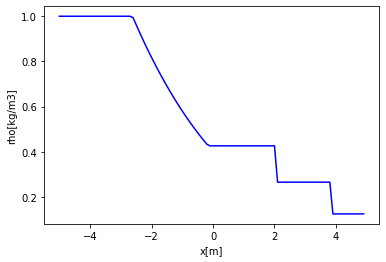

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
x = np.arange(XL, XR, dx)

# アニメーション
ims_rho = []
it = 0
t = 0

while t <= tstop:
    im_rho = plt.plot(x, rhoet[it], "b")
    ims_rho.append(im_rho)
    plt.xlabel("x[m]")
    plt.ylabel("rho[kg/m3]")
    t = t + dt
    it += 1

ani_rho = animation.ArtistAnimation(fig, ims_rho, interval=1)
ani_rho.save('rho.gif', writer='pillow')

流速のグラフを作成

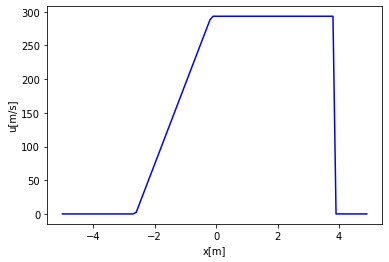

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
x = np.arange(XL, XR, dx)

# アニメーション
ims_u = []
it = 0
t = 0
while t <= tstop:
    im_u = plt.plot(x, uet[it], "b")
    ims_u.append(im_u)
    
    plt.xlabel("x[m]")
    plt.ylabel("u[m/s]")
    
    t = t + dt
    it += 1

ani_u = animation.ArtistAnimation(fig, ims_u, interval=1)
ani_u.save('u.gif', writer='pillow')

圧力のグラフを作成

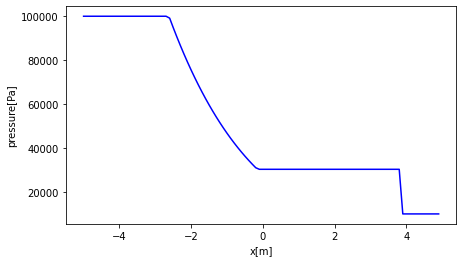

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(7,4))
x = np.arange(XL, XR, dx)

# アニメーション
ims_p = []
it = 0
t = 0
while t <= tstop:
    im_p = plt.plot(x, pet[it], "b")
    plt.xlabel("x[m]")
    plt.ylabel("pressure[Pa]")
    ims_p.append(im_p)
    t = t + dt
    it += 1

ani_p = animation.ArtistAnimation(fig, ims_p, interval=1)
ani_p.save('p.gif', writer='pillow')

温度のグラフを作成

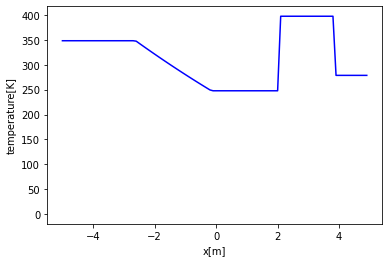

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
x = np.arange(XL, XR, dx)

# アニメーション
ims_t = []
it = 0
t = 0
while t <= tstop:
    im_t = plt.plot(x, tempet[it], "b")
    plt.xlabel("x[m]")
    plt.ylabel("temperature[K]")
    ims_t.append(im_t)
    t = t + dt    
    it += 1

ani_t = animation.ArtistAnimation(fig, ims_t, interval=1)
ani_t.save('tempe.gif', writer='pillow')

以上の結果をOpenFOAMと比較を行うためにcsvファイルとして出力しておく

In [14]:
it = 0
t = 0

cols=["#x[m]", "temp[K]", "p[Pa]", "rho[kg/m3]", "u[m/s]"]
while t <= tstop:
    time = round(t,4)
    if time>0 and time%0.0010 == 0:
        df = pd.DataFrame([x ,tempet[it],  pet[it], rhoet[it], uet[it],]).T
        df.columns = cols
        df.to_csv(f"time{round(t,3)}.csv", index=False, sep='\t')
    t = t + dt
    it += 1

# OpenFOAMとの比較

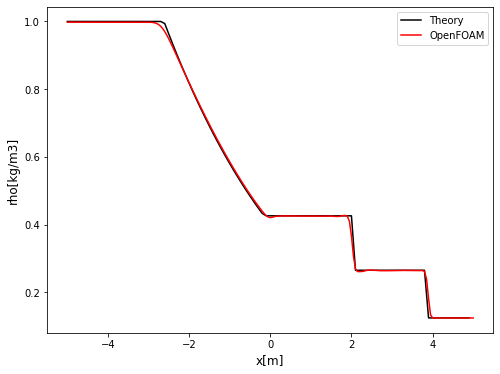

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

fig = plt.figure(figsize=(8,6))
x = np.arange(XL, XR, dx)

# OpenFOAMのデータフレーム作成関数
def df_cae_func(time_):
    datafilename = "x_sec_T_mag(U)_p_rho.xy"
    filenamepath = f"../shockTube/postProcessing/sampleDict/{time_}/{datafilename}"
    cols = ["x[m]", "T[K]", "U[m/s]", "p[Pa]", "rho[kg/m3]"]
    df_cae = pd.read_table(filenamepath, names=cols)
    return df_cae

# アニメーション
ims_rho_exp_cae = []
it = 0
t = 0
df_cae = pd.DataFrame()
while t <= tstop:
    time = round(t,4)
    if time>0 and time%0.0010 == 0:
        if time == 0.0070:
             # 理論解    
            im_rho = plt.plot(x, rhoet[it], color="black",label="Theory")

            # OpenFOAM
            df_cae = df_cae_func(time)
            im_rho_cae = plt.plot(df_cae["x[m]"].values, df_cae["rho[kg/m3]"].values, color="red", label="OpenFOAM")
        else: 
            # 理論解    
            im_rho = plt.plot(x, rhoet[it], color="black")#, label="Theory")

            # OpenFOAM
            df_cae = df_cae_func(time)
            im_rho_cae = plt.plot(df_cae["x[m]"].values, df_cae["rho[kg/m3]"].values, color="red")#, label="OpenFOAM")
        
        ims_rho_exp_cae.append(im_rho + im_rho_cae)

    t = t + dt
    it += 1

plt.xlabel("x[m]", fontsize=12)
plt.ylabel("rho[kg/m3]", fontsize=12)
plt.legend()
ani_rho = animation.ArtistAnimation(fig, ims_rho_exp_cae, interval=1)#, repeat_delay=1000)
ani_rho.save('rho_exp_cae.gif', writer='pillow')